In [1]:
import os
os.chdir('C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\pyimagesearch')
from timeseires.CNN1D.GoogLeNet1D import PC
from timeseires.utils.to_split import to_split
#from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from timeseires.utils.load_only_multi_step import load_only_multi_step
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD  
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import pydot
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Dense, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate
from tensorflow.keras.regularizers import l2


In [2]:
path_tr = 'C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\AEP\\AEP_train.csv'
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values 

path_v = 'C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\AEP\\AEP_validation.csv'
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 

path_te = 'C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\AEP\\AEP_test.csv'
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 
#.......................................................................................................
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\AEP\\AEP_scaler.pkl", 'rb'))
df_te.shape,df_v.shape

((12130, 21), (24259, 21))

In [3]:
time_steps=24
num_features=21

In [4]:
start = time.time()
train_X, train_y = multivariate_multi_step(train_set, time_steps = time_steps, target_col = 0,target_len=24,ahead=0)
validation_X, validation_y = multivariate_multi_step(validation_set, time_steps =time_steps ,target_col=0,target_len=24,ahead=0)
test_X, test_y = multivariate_multi_step(test_set, time_steps = time_steps, target_col= 0,target_len=24,ahead=0)
print('Time Consumed',time.time()-start,"sec")

Time Consumed 1.5506446361541748 sec


In [5]:
start = time.time()
train_X_load, train_y_load = load_only_multi_step(train_set, time_steps = time_steps, target_col = 0,target_len=24)
validation_X_load, validation_y_load = load_only_multi_step(validation_set, time_steps =time_steps ,target_col=0,target_len=24)
test_X_load, test_y_load = load_only_multi_step(test_set, time_steps = time_steps, target_col= 0,target_len=24)
print('Time Consumed',time.time()-start,"sec")

Time Consumed 0.7686996459960938 sec


In [6]:
#EXP 1 STEPS 24 LOOKBACK 72

In [7]:
def review_goog():   
    inputs_combine = Input(shape=(time_steps, num_features))
    lstm1   = LSTM(20, return_sequences = True)(inputs_combine)
    lstm2   = LSTM(20)(lstm1)
    #--------------------------------------------------------
    inputs_load = Input(shape=(time_steps, 1))
    l = Bidirectional(LSTM(32, return_sequences=True))(inputs_load)
    l = Bidirectional(LSTM(32, return_sequences=True))(l)
    
    c11 = PC.inception_module(inputs_load, 32, 32, 64, 8, 32, "2a", 0.01)
    c21 = PC.inception_module(c11, 64, 64, 128, 16, 64, "3a", 0.01)
    
    #---------------------------------------------------------
    y = Concatenate(axis=-1)([inputs_load, l, c21])

    #y= PC.conv_module(y, 128, 3, 1)
    x = Flatten()(y)
    
    x = Concatenate(axis=-1)([x, lstm2])
    
    x = Dense(24, activation="sigmoid")(x)
    
    model = Model(inputs=[inputs_load,inputs_combine], outputs=x)
    return model

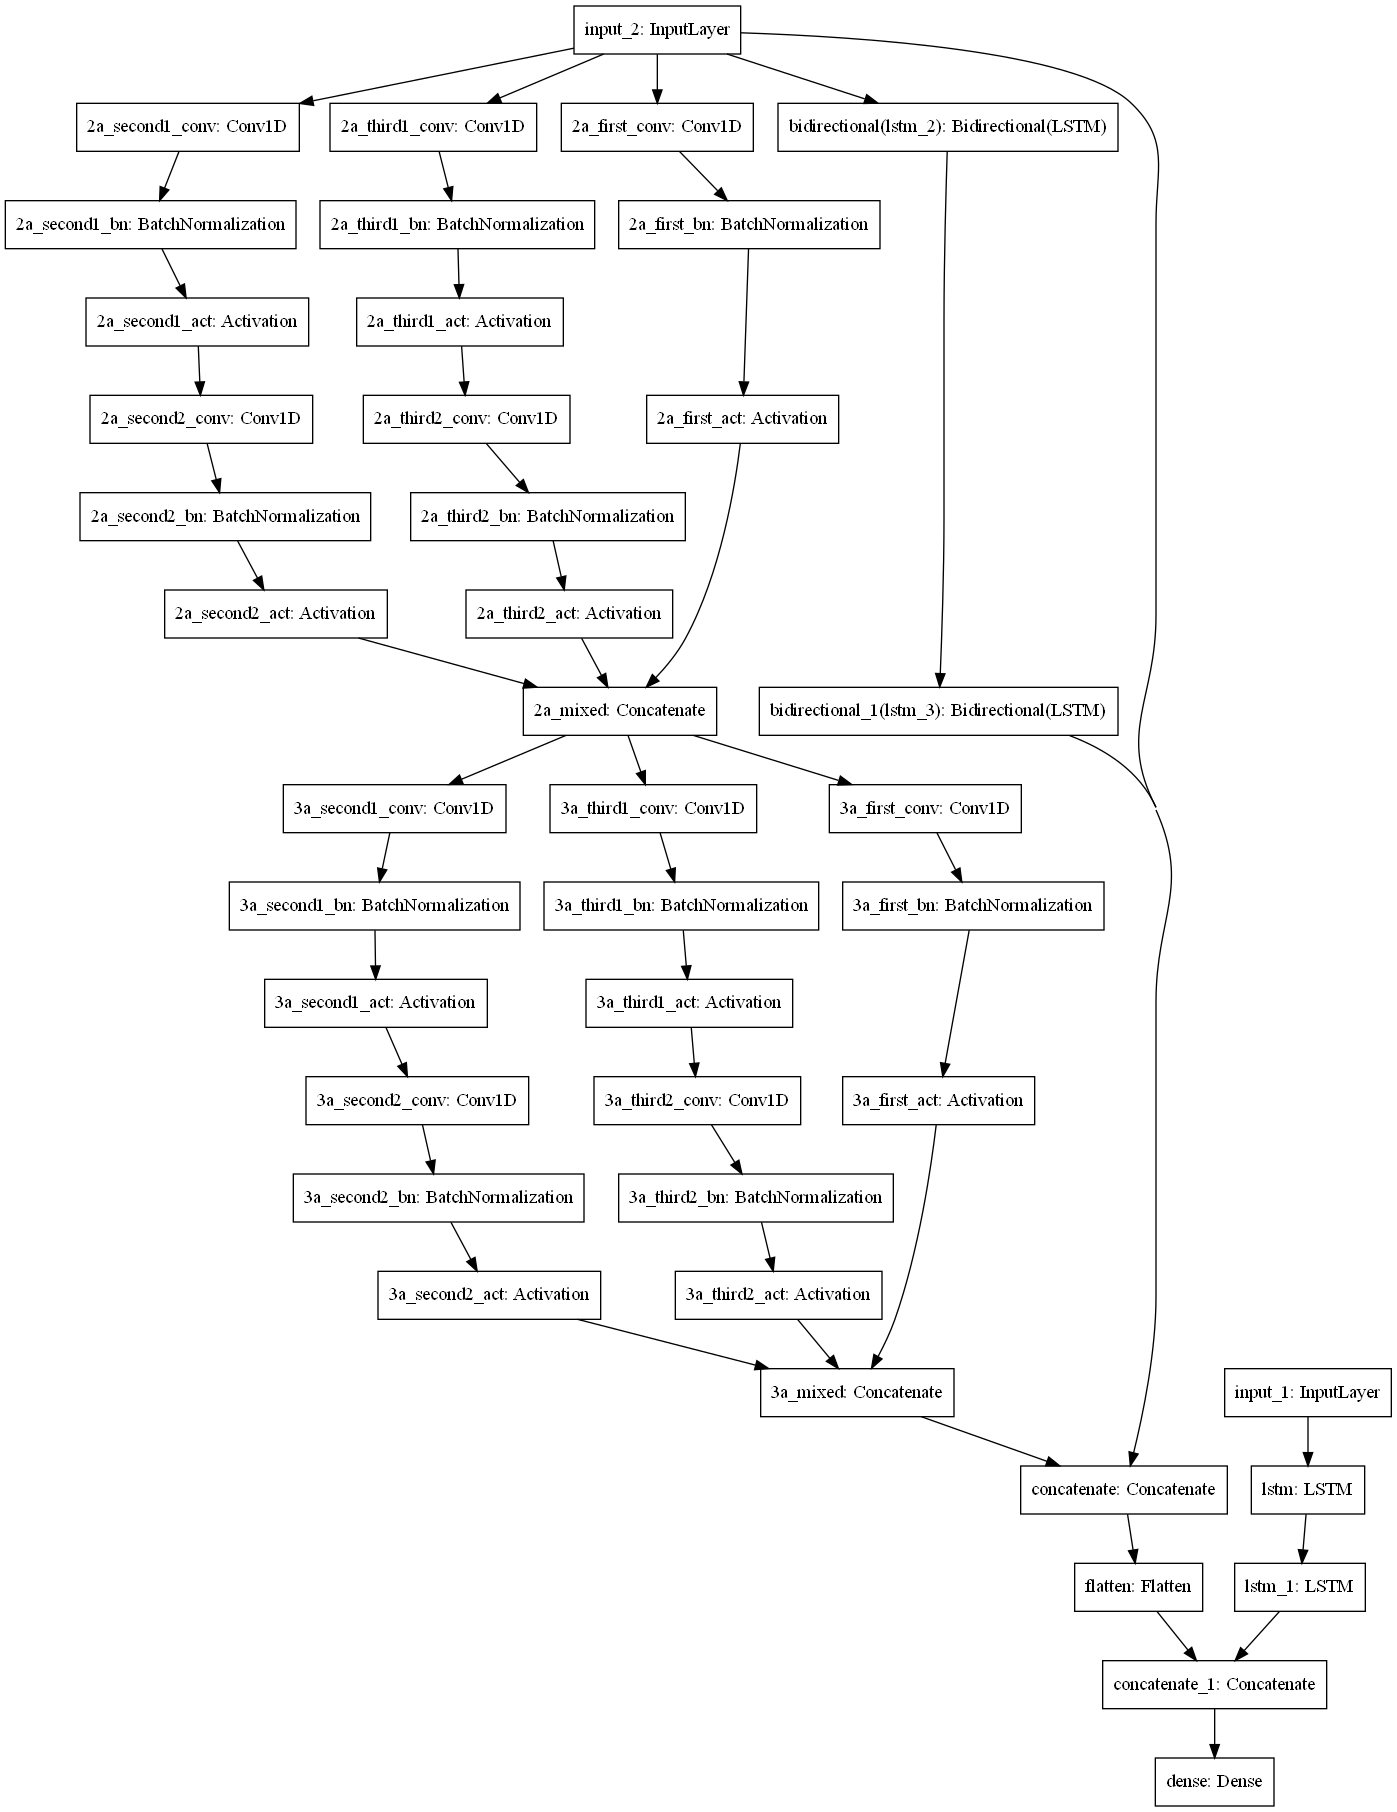

In [8]:
model = review_goog()
tensorflow.keras.utils.plot_model(model)

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
2a_second1_conv (Conv1D)        (None, 24, 32)       64          input_2[0][0]                    
__________________________________________________________________________________________________
2a_third1_conv (Conv1D)         (None, 24, 8)        16          input_2[0][0]                    
__________________________________________________________________________________________________
2a_second1_bn (BatchNormalizati (None, 24, 32)       128         2a_second1_conv[0][0]            
_______________________________________________________________________________________

In [10]:
checkpoints = 'D:\\Checkpoints\\1_ieee_industrial info\\rewiev\\1_ModifiedGoogLeNet\\4\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = 'D:\\Checkpoints\\1_ieee_industrial info\\rewiev\\1_ModifiedGoogLeNet\\4'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [6]:
model = None
start_epoch = 0
time_steps=24
num_features=21

In [12]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [13]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = review_goog()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [14]:
epochs = 100
verbose = 1 #0
batch_size = 32
History = model.fit(x= [train_X_load,train_X],
                        y=train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = ([validation_X_load, validation_X], validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/100
2650/2652 [============================>.] - ETA: 0s - loss: 0.1210 - mae: 0.0442 - mape: 2410.2810
Epoch 00001: val_loss improved from inf to 0.03803, saving model to D:\Checkpoints\1_ieee_industrial info\rewiev\1_ModifiedGoogLeNet\4\E1-cp-0001-loss0.04.h5
2652/2652 [==============================] - 41s 15ms/step - loss: 0.1209 - mae: 0.0442 - mape: 2408.6121 - val_loss: 0.0380 - val_mae: 0.0373 - val_mape: 17.6227
Epoch 2/100
2649/2652 [============================>.] - ETA: 0s - loss: 0.0348 - mae: 0.0342 - mape: 2304.6104
Epoch 00002: val_loss improved from 0.03803 to 0.03744, saving model to D:\Checkpoints\1_ieee_industrial info\rewiev\1_ModifiedGoogLeNet\4\E1-cp-0002-loss0.04.h5
2652/2652 [==============================] - 39s 15ms/step - loss: 0.0348 - mae: 0.0342 - mape: 2302.1531 - val_loss: 0.0374 - val_mae: 0.0369 - val_mape: 16.4520
Epoch 3/100
2651/2652 [============================>.] - ETA: 0s - loss: 0.0338 - mae: 0.0333 - mape: 2323.0139
Epoch 00003: val_l

Epoch 24/100
2652/2652 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.0278 - mape: 2080.5378
Epoch 00024: val_loss improved from 0.03112 to 0.03092, saving model to D:\Checkpoints\1_ieee_industrial info\rewiev\1_ModifiedGoogLeNet\4\E1-cp-0024-loss0.03.h5
2652/2652 [==============================] - 38s 14ms/step - loss: 0.0278 - mae: 0.0278 - mape: 2080.5378 - val_loss: 0.0309 - val_mae: 0.0309 - val_mape: 13.6568
Epoch 25/100
2649/2652 [============================>.] - ETA: 0s - loss: 0.0277 - mae: 0.0277 - mape: 2080.5537
Epoch 00025: val_loss did not improve from 0.03092
2652/2652 [==============================] - 39s 15ms/step - loss: 0.0277 - mae: 0.0277 - mape: 2078.3320 - val_loss: 0.0310 - val_mae: 0.0310 - val_mape: 13.5434
Epoch 26/100
2652/2652 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.0276 - mape: 2115.5503
Epoch 00026: val_loss did not improve from 0.03092
2652/2652 [==============================] - 39s 15ms/step - loss: 0.02

Epoch 48/100
2652/2652 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.0258 - mape: 1916.4114
Epoch 00048: val_loss did not improve from 0.03037
2652/2652 [==============================] - 39s 15ms/step - loss: 0.0258 - mae: 0.0258 - mape: 1916.4114 - val_loss: 0.0316 - val_mae: 0.0316 - val_mape: 13.8799
Epoch 49/100
2652/2652 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.0257 - mape: 1914.7401
Epoch 00049: val_loss did not improve from 0.03037
2652/2652 [==============================] - 39s 15ms/step - loss: 0.0257 - mae: 0.0257 - mape: 1914.7401 - val_loss: 0.0324 - val_mae: 0.0324 - val_mape: 14.1227
Epoch 50/100
2652/2652 [==============================] - ETA: 0s - loss: 0.0256 - mae: 0.0256 - mape: 1908.5623
Epoch 00050: val_loss did not improve from 0.03037
2652/2652 [==============================] - 40s 15ms/step - loss: 0.0256 - mae: 0.0256 - mape: 1908.5623 - val_loss: 0.0312 - val_mae: 0.0312 - val_mape: 13.5891
Epoch 51/100
2650/2

KeyboardInterrupt: 

In [18]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\rewiev\\1_ModifiedGoogLeNet\\4\\E1-cp-0046-loss0.03.h5')
#scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict([test_X_load,test_X]) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 493.12
Median Absolute Error (MedAE): 329.1
Mean Squared Error (MSE): 497865.95
Root Mean Squared Error (RMSE): 705.6
Mean Absolute Percentage Error (MAPE): 3.29 %
Median Absolute Percentage Error (MDAPE): 2.3 %


y_test_unscaled.shape=  (12082, 24)
y_pred.shape=  (12082, 24)


# T1

In [19]:
checkpoints = 'D:\\Checkpoints\\1_ieee_industrial info\\rewiev\\1_ModifiedGoogLeNet\\4\\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\1_ieee_industrial info\\rewiev\\1_ModifiedGoogLeNet\\4\\E1-cp-0046-loss0.03.h5'
start_epoch= 47

In [20]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [21]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\1_ieee_industrial info\rewiev\1_ModifiedGoogLeNet\4\E1-cp-0046-loss0.03.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [22]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(x= [train_X_load,train_X],
                        y=train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = ([validation_X_load, validation_X], validation_y_load),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/60
2652/2652 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 1943.2727
Epoch 00001: val_loss improved from inf to 0.03043, saving model to D:\Checkpoints\1_ieee_industrial info\rewiev\1_ModifiedGoogLeNet\4\E2-cp-0001-loss0.03.h5
2652/2652 [==============================] - 43s 16ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 1943.2727 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304 - val_mean_absolute_percentage_error: 13.1013
Epoch 2/60
2652/2652 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 1940.3448
Epoch 00002: val_loss did not improve from 0.03043
2652/2652 [==============================] - 42s 16ms/step - loss: 0.0246 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 1940.3448 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306 - val_mean_absolute_percentage_error:

Epoch 19/60
2652/2652 [==============================] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.0243 - mean_absolute_percentage_error: 1913.0811
Epoch 00019: val_loss did not improve from 0.03033
2652/2652 [==============================] - 40s 15ms/step - loss: 0.0243 - mean_absolute_error: 0.0243 - mean_absolute_percentage_error: 1913.0811 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307 - val_mean_absolute_percentage_error: 13.1788
Epoch 20/60
2649/2652 [============================>.] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.0243 - mean_absolute_percentage_error: 1912.9541
Epoch 00020: val_loss did not improve from 0.03033
2652/2652 [==============================] - 41s 16ms/step - loss: 0.0243 - mean_absolute_error: 0.0243 - mean_absolute_percentage_error: 1910.9117 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306 - val_mean_absolute_percentage_error: 13.0973
Epoch 21/60
2652/2652 [==============================] - ETA: 0s - loss: 0.0243 - mean_absolute_

Epoch 37/60
2649/2652 [============================>.] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 1870.4247
Epoch 00037: val_loss did not improve from 0.03033
2652/2652 [==============================] - 39s 15ms/step - loss: 0.0241 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 1868.4257 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308 - val_mean_absolute_percentage_error: 13.3510
Epoch 38/60
2651/2652 [============================>.] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 1869.1722
Epoch 00038: val_loss did not improve from 0.03033
2652/2652 [==============================] - 41s 15ms/step - loss: 0.0241 - mean_absolute_error: 0.0241 - mean_absolute_percentage_error: 1868.5807 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306 - val_mean_absolute_percentage_error: 13.0855
Epoch 39/60
1336/2652 [==============>...............] - ETA: 19s - loss: 0.0240 - mean_absolute

KeyboardInterrupt: 

In [26]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\rewiev\\1_ModifiedGoogLeNet\\4\\E2-cp-0001-loss0.03.h5')
#scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict([test_X_load,test_X]) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 495.6
Median Absolute Error (MedAE): 332.51
Mean Squared Error (MSE): 499763.32
Root Mean Squared Error (RMSE): 706.94
Mean Absolute Percentage Error (MAPE): 3.3 %
Median Absolute Percentage Error (MDAPE): 2.32 %


y_test_unscaled.shape=  (12082, 24)
y_pred.shape=  (12082, 24)


In [7]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\rewiev\\1_ModifiedGoogLeNet\\8\\E1-cp-0028-loss0.03.h5')
#scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict([test_X_load,test_X]) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 486.16
Median Absolute Error (MedAE): 331.9
Mean Squared Error (MSE): 473735.19
Root Mean Squared Error (RMSE): 688.28
Mean Absolute Percentage Error (MAPE): 3.24 %
Median Absolute Percentage Error (MDAPE): 2.31 %


y_test_unscaled.shape=  (12082, 24)
y_pred.shape=  (12082, 24)


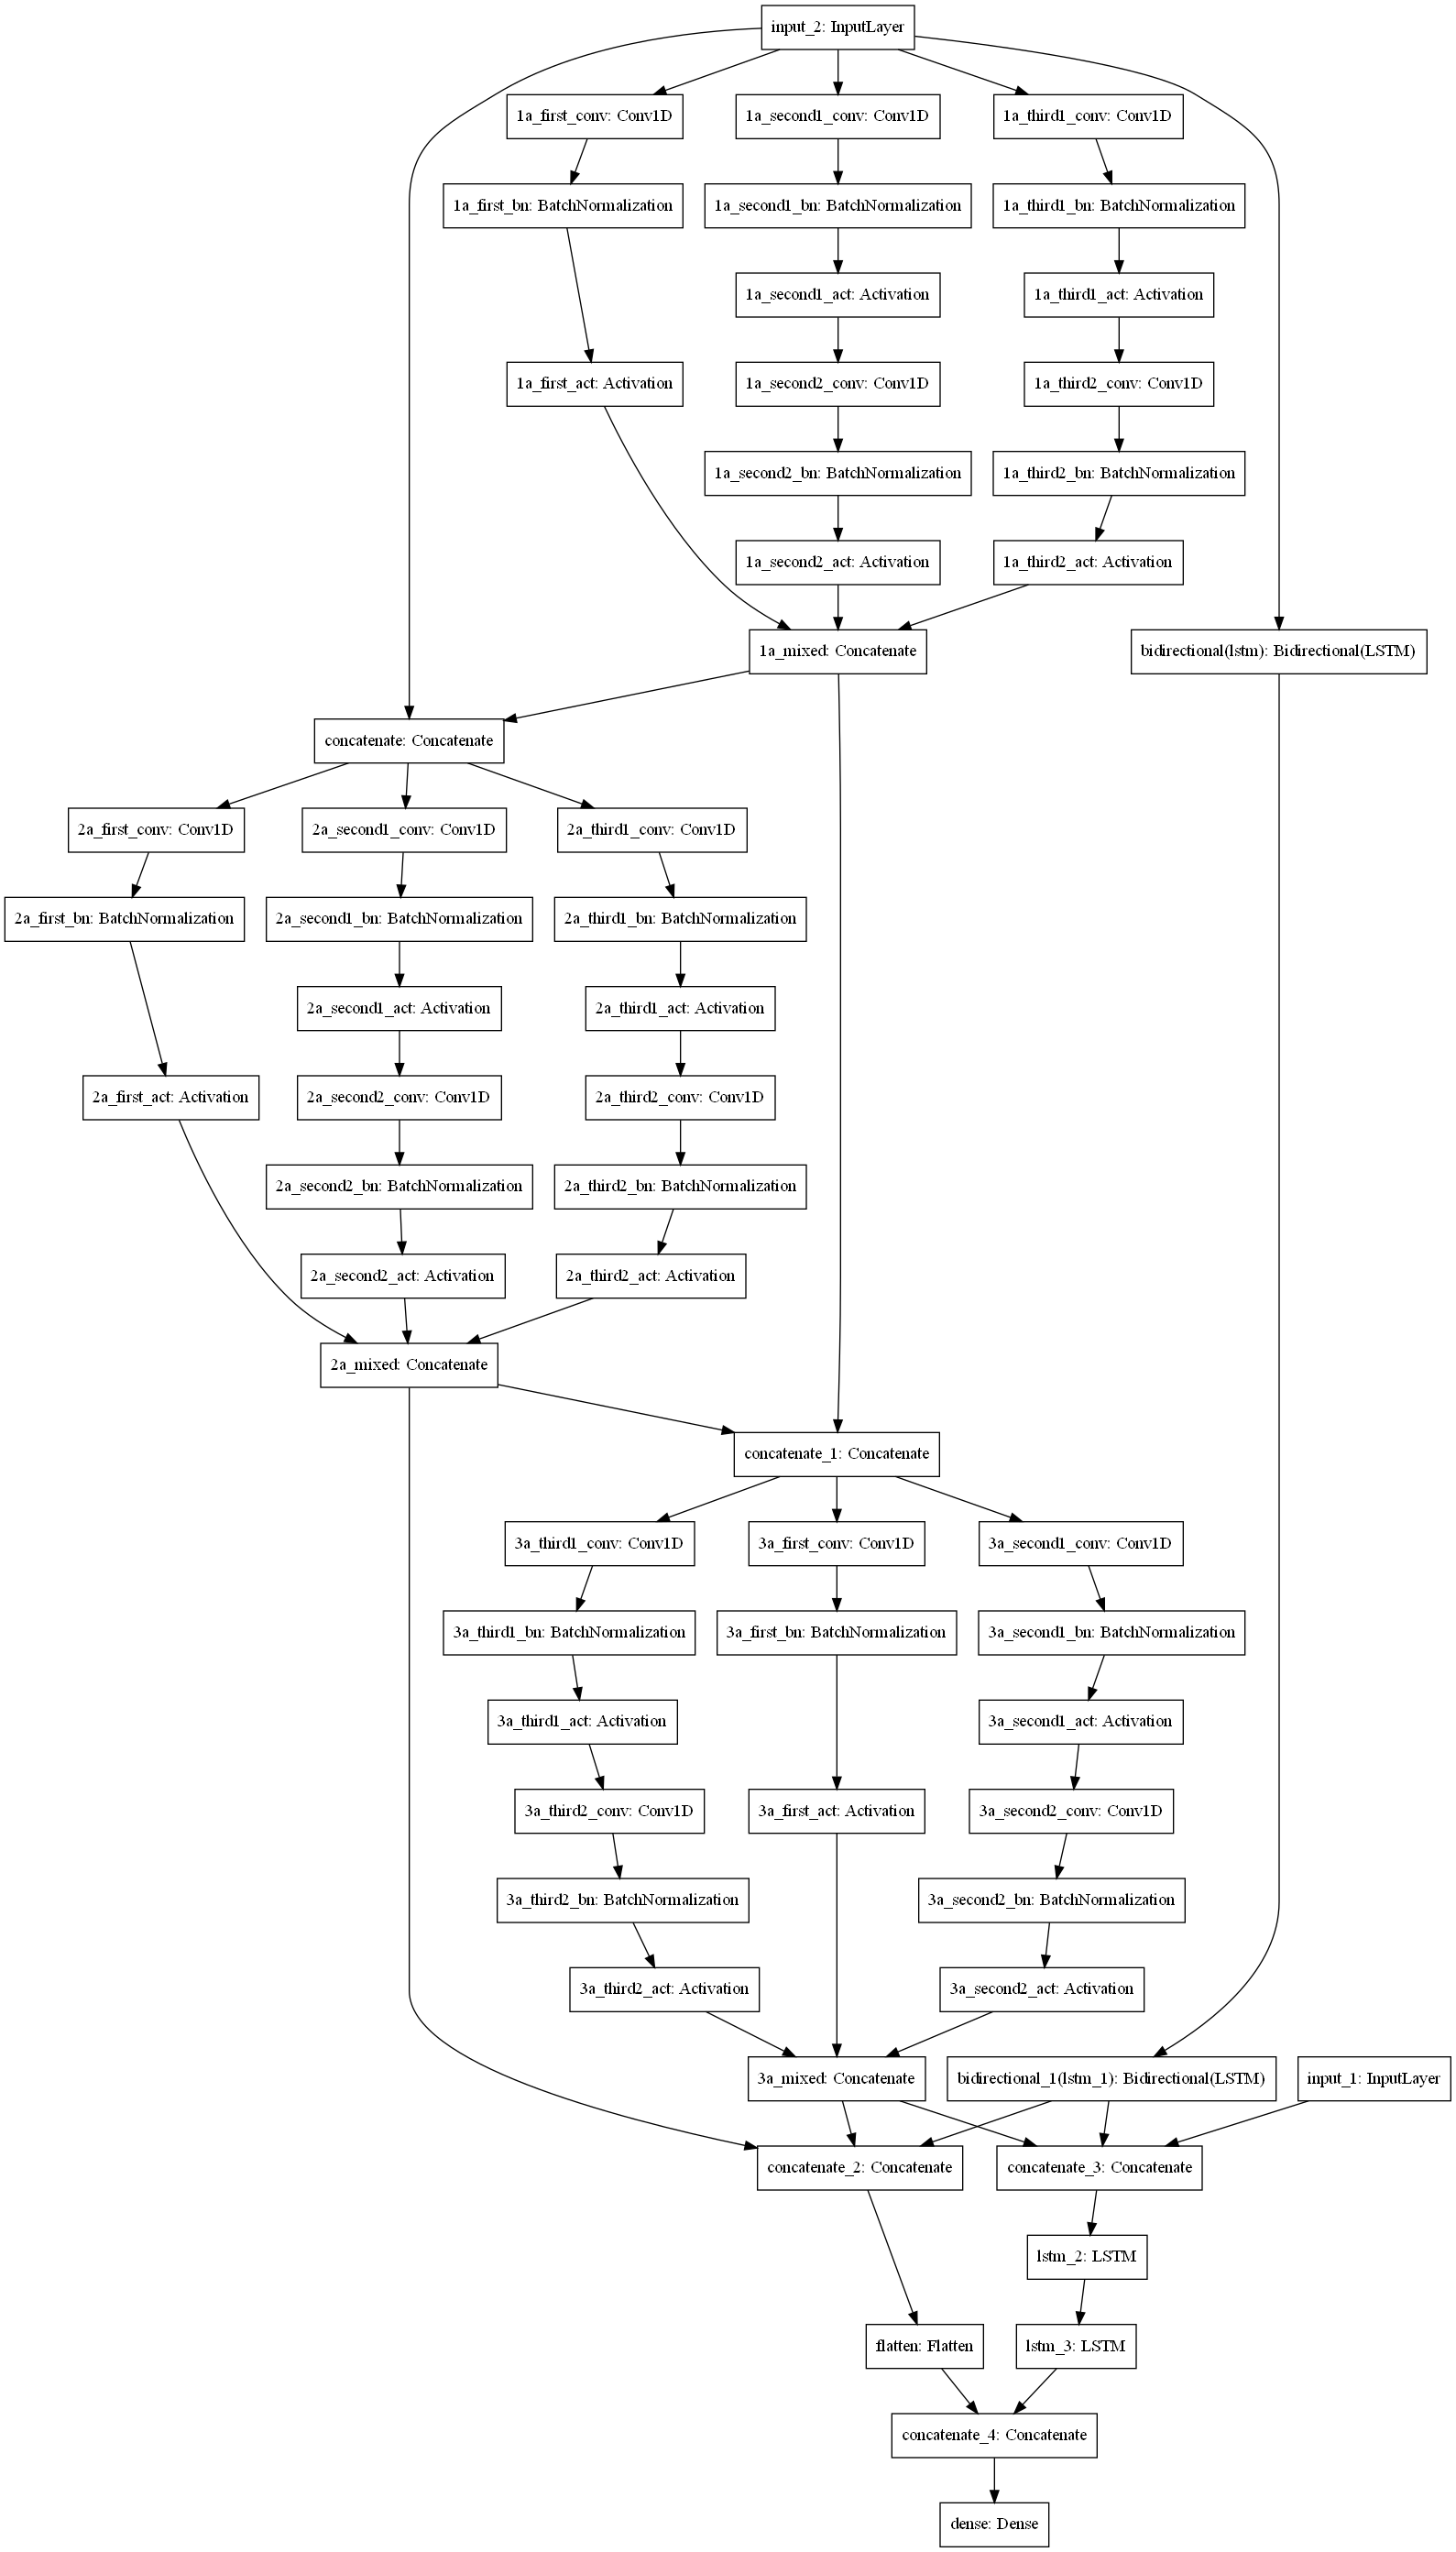

In [22]:
model = review_goog()
tensorflow.keras.utils.plot_model(model)

# T2

In [37]:
checkpoints='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\1\\E3_cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\1\\E2-cp-0006-loss0.04.h5'
start_epoch= 59+6

In [38]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [39]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-5)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\1\E2-cp-0006-loss0.04.h5...
[INFO] old learning rate: 9.999999747378752e-05
[INFO] new learning rate: 9.999999747378752e-06


In [40]:
epochs = 200
verbose = 1 #0
batch_size = 1024
History = model.fit(train_X,
                        train_y, 
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Train on 32614 samples, validate on 9250 samples
Epoch 1/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0235 - mae: 0.0231 - mape: 8601.9141
Epoch 00001: val_loss improved from inf to 0.03575, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\1\E3_cp-0001-loss0.04.h5
32614/32614 [==============================] - 7s 210us/sample - loss: 0.0235 - mae: 0.0231 - mape: 8729.3066 - val_loss: 0.0358 - val_mae: 0.0353 - val_mape: 6.1952
Epoch 2/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0235 - mae: 0.0230 - mape: 8563.2227
Epoch 00002: val_loss improved from 0.03575 to 0.03574, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\1\E3_cp-0002-loss0.04.h5
32614/32614 [==============================] - 3s 107us/sample - loss: 0.0235 - mae: 0.0230 - mape: 8710.7080 - val_loss: 0.0357 - val_mae: 0.0353 - val_mape: 6.1938
Epoch 3/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0234 - mae: 0.

KeyError: 'val_loss'

In [41]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\1\\E3_cp-0004-loss0.04.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 541.71
Median Absolute Error (MedAE): 449.47
Mean Squared Error (MSE): 473684.02
Root Mean Squared Error (RMSE): 688.25
Mean Absolute Percentage Error (MAPE): 5.4 %
Median Absolute Percentage Error (MDAPE): 4.39 %


y_test_unscaled.shape=  (4576, 24)
y_pred.shape=  (4576, 24)


# E2

In [24]:
class PC:
    @staticmethod
    def conv_module(x, num_filter, kr, stride ,padding="same", reg=0.0005, name=None):
        # initialize the CONV, BN, and RELU layer names
        (convName, bnName, actName) = (None, None, None)
        
        # if a layer name was supplied, prepend it
        if name is not None:
            convName = name + "_conv"
            bnName = name + "_bn"
            actName = name + "_act"
        # define a CONV => BN => RELU pattern
        x = Conv1D(num_filter, kr, strides=stride, padding=padding, kernel_regularizer=l2(reg),name=convName)(x)
        x = BatchNormalization(axis=-1, name=bnName)(x)
        x = Activation("relu", name=actName)(x)
        
        # return the block
        return x
    
    @staticmethod
    def inception_module(x, num1x1, num3x3Reduce, num3x3,num5x5Reduce, num5x5, stage, reg=0.0005):
        # define the first branch of the Inception module which
        # consists of 1x1 convolutions
        first = PC.conv_module(x, num1x1, 1, 1, reg=reg, name=stage + "_first")
        
        # define the second branch of the Inception module which
        # consists of 1x1 and 3x3 convolutions
        second = PC.conv_module(x, num3x3Reduce, 1, 1,  reg=reg, name=stage + "_second1")
        second = PC.conv_module(second, num3x3, 3, 1, reg=reg, name=stage + "_second2")
        
        # define the third branch of the Inception module which
        # are our 1x1 and 5x5 convolutions
        third = PC.conv_module(x, num5x5Reduce, 1, 1,  reg=reg, name=stage + "_third1")
        third = PC.conv_module(third, num5x5, 5, 1,  reg=reg, name=stage + "_third2")
        
        # concatenate across the channel dimension
        x = concatenate([first, second, third], axis=-1 ,name=stage + "_mixed")
        
        # return the block
        return x
    @staticmethod
    def build(time_steps, num_features, reg=0.0005):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        # define the model input and first CONV module
        inputs = Input(shape=(time_steps, num_features))
        x = LSTM(48, return_sequences=True)(inputs)
        x = Activation('relu')(x)
        x = PC.conv_module(x, 32, 7, 1)
        x = PC.conv_module(x, 64, 3, 1)
        x = PC.inception_module(x, 32, 32, 64, 8, 32, "2a")
        x = MaxPooling1D(2)(x)
        x = PC.inception_module(x, 64, 64, 128, 16, 64, "3a")
#.......................................................................
        x = Flatten()(x)
        x = Dense(200, activation='relu')(x)
 #       x = Dense(10, activation='relu')(x)
        x = Dense(24)(x)
        #x = Dense(1)(x)
        
#.......................................................................
        # create the model
        model = Model(inputs, x, name="PC")
        
        # return the constructed network architecture
        return model

In [25]:
checkpoints = 'D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = 'D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [26]:
model = None
start_epoch = 0
time_steps=72
num_features=17

In [27]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [28]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [29]:
epochs = 80
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Train on 32614 samples, validate on 9250 samples
Epoch 1/80
32544/32614 [============================>.] - ETA: 0s - loss: 0.2038 - mae: 0.0831 - mape: 10284.1670
Epoch 00001: val_loss improved from inf to 0.10131, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E1-cp-0001-loss0.10.h5
32614/32614 [==============================] - 19s 581us/sample - loss: 0.2036 - mae: 0.0830 - mape: 10262.1201 - val_loss: 0.1013 - val_mae: 0.0675 - val_mape: 11.9466
Epoch 2/80
32544/32614 [============================>.] - ETA: 0s - loss: 0.0654 - mae: 0.0492 - mape: 9617.4668
Epoch 00002: val_loss improved from 0.10131 to 0.07428, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E1-cp-0002-loss0.07.h5
32614/32614 [==============================] - 14s 420us/sample - loss: 0.0654 - mae: 0.0492 - mape: 9596.8438 - val_loss: 0.0743 - val_mae: 0.0671 - val_mape: 11.8373
Epoch 3/80
32448/32614 [============================>.] - ETA: 0s - loss: 0.0511 - mae:

Epoch 24/80
32608/32614 [============================>.] - ETA: 0s - loss: 0.0360 - mae: 0.0354 - mape: 9481.0664
Epoch 00024: val_loss did not improve from 0.04432
32614/32614 [==============================] - 13s 412us/sample - loss: 0.0360 - mae: 0.0354 - mape: 9479.3242 - val_loss: 0.0482 - val_mae: 0.0476 - val_mape: 8.8535
Epoch 25/80
32512/32614 [============================>.] - ETA: 0s - loss: 0.0359 - mae: 0.0353 - mape: 9452.0479
Epoch 00025: val_loss did not improve from 0.04432
32614/32614 [==============================] - 13s 411us/sample - loss: 0.0359 - mae: 0.0353 - mape: 9422.5107 - val_loss: 0.0450 - val_mae: 0.0444 - val_mape: 8.3675
Epoch 26/80
32512/32614 [============================>.] - ETA: 0s - loss: 0.0358 - mae: 0.0352 - mape: 9389.7109
Epoch 00026: val_loss did not improve from 0.04432
32614/32614 [==============================] - 13s 413us/sample - loss: 0.0358 - mae: 0.0352 - mape: 9360.3701 - val_loss: 0.0505 - val_mae: 0.0499 - val_mape: 8.9818
Epoc

Epoch 47/80
32480/32614 [============================>.] - ETA: 0s - loss: 0.0276 - mae: 0.0269 - mape: 8903.1064
Epoch 00047: val_loss did not improve from 0.03728
32614/32614 [==============================] - 14s 418us/sample - loss: 0.0276 - mae: 0.0269 - mape: 8866.5479 - val_loss: 0.0456 - val_mae: 0.0449 - val_mape: 7.3343
Epoch 48/80
32544/32614 [============================>.] - ETA: 0s - loss: 0.0270 - mae: 0.0264 - mape: 8938.7715
Epoch 00048: val_loss did not improve from 0.03728
32614/32614 [==============================] - 14s 417us/sample - loss: 0.0270 - mae: 0.0264 - mape: 8919.5977 - val_loss: 0.0419 - val_mae: 0.0413 - val_mape: 6.8349
Epoch 49/80
32512/32614 [============================>.] - ETA: 0s - loss: 0.0272 - mae: 0.0265 - mape: 8954.8320
Epoch 00049: val_loss improved from 0.03728 to 0.03701, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E1-cp-0049-loss0.04.h5
32614/32614 [==============================] - 14s 419us/sample - loss

Epoch 71/80
32544/32614 [============================>.] - ETA: 0s - loss: 0.0254 - mae: 0.0247 - mape: 8894.0742
Epoch 00071: val_loss did not improve from 0.03603
32614/32614 [==============================] - 14s 415us/sample - loss: 0.0254 - mae: 0.0247 - mape: 8874.9961 - val_loss: 0.0447 - val_mae: 0.0440 - val_mape: 7.2170
Epoch 72/80
32544/32614 [============================>.] - ETA: 0s - loss: 0.0253 - mae: 0.0246 - mape: 8940.8789
Epoch 00072: val_loss did not improve from 0.03603
32614/32614 [==============================] - 14s 414us/sample - loss: 0.0253 - mae: 0.0246 - mape: 8921.6992 - val_loss: 0.0399 - val_mae: 0.0393 - val_mape: 6.6394
Epoch 73/80
31840/32614 [============================>.] - ETA: 0s - loss: 0.0252 - mae: 0.0246 - mape: 8697.8066

KeyError: 'val_loss'

In [32]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E1-cp-0052-loss0.04.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 577.97
Median Absolute Error (MedAE): 474.07
Mean Squared Error (MSE): 554533.54
Root Mean Squared Error (RMSE): 744.67
Mean Absolute Percentage Error (MAPE): 5.86 %
Median Absolute Percentage Error (MDAPE): 4.58 %


y_test_unscaled.shape=  (4576, 24)
y_pred.shape=  (4576, 24)


# T1

In [41]:
checkpoints='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E2_cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E1-cp-0052-loss0.04.h5'
start_epoch= 53

In [42]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [43]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E1-cp-0052-loss0.04.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [44]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Train on 32614 samples, validate on 9250 samples
Epoch 1/60
32608/32614 [============================>.] - ETA: 0s - loss: 0.0241 - mae: 0.0235 - mape: 8787.5186
Epoch 00001: val_loss improved from inf to 0.03371, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E2_cp-0001-loss0.03.h5
32614/32614 [==============================] - 57s 2ms/sample - loss: 0.0241 - mae: 0.0235 - mape: 8785.9023 - val_loss: 0.0337 - val_mae: 0.0331 - val_mape: 5.6219
Epoch 2/60
32576/32614 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0216 - mape: 8818.7939
Epoch 00002: val_loss improved from 0.03371 to 0.03268, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E2_cp-0002-loss0.03.h5
32614/32614 [==============================] - 53s 2ms/sample - loss: 0.0222 - mae: 0.0216 - mape: 8808.5244 - val_loss: 0.0327 - val_mae: 0.0321 - val_mape: 5.5019
Epoch 3/60
32608/32614 [============================>.] - ETA: 0s - loss: 0.0219 - mae: 0.0214 

Epoch 25/60
32576/32614 [============================>.] - ETA: 0s - loss: 0.0208 - mae: 0.0204 - mape: 8417.9062
Epoch 00025: val_loss did not improve from 0.03238
32614/32614 [==============================] - 53s 2ms/sample - loss: 0.0208 - mae: 0.0204 - mape: 8762.0635 - val_loss: 0.0330 - val_mae: 0.0326 - val_mape: 5.5165
Epoch 26/60
32576/32614 [============================>.] - ETA: 0s - loss: 0.0207 - mae: 0.0203 - mape: 8781.5459
Epoch 00026: val_loss did not improve from 0.03238
32614/32614 [==============================] - 53s 2ms/sample - loss: 0.0207 - mae: 0.0203 - mape: 8771.3203 - val_loss: 0.0333 - val_mae: 0.0329 - val_mape: 5.5305
Epoch 27/60
32576/32614 [============================>.] - ETA: 0s - loss: 0.0207 - mae: 0.0203 - mape: 8805.2725
Epoch 00027: val_loss did not improve from 0.03238
32614/32614 [==============================] - 53s 2ms/sample - loss: 0.0207 - mae: 0.0203 - mape: 8795.0176 - val_loss: 0.0328 - val_mae: 0.0324 - val_mape: 5.5373
Epoch 28/6

Epoch 50/60
32576/32614 [============================>.] - ETA: 0s - loss: 0.0198 - mae: 0.0195 - mape: 8912.0732
Epoch 00050: val_loss did not improve from 0.03238
32614/32614 [==============================] - 53s 2ms/sample - loss: 0.0198 - mae: 0.0195 - mape: 8901.6934 - val_loss: 0.0326 - val_mae: 0.0322 - val_mape: 5.5117
Epoch 51/60
32608/32614 [============================>.] - ETA: 0s - loss: 0.0198 - mae: 0.0194 - mape: 8897.9141
Epoch 00051: val_loss did not improve from 0.03238
32614/32614 [==============================] - 53s 2ms/sample - loss: 0.0198 - mae: 0.0194 - mape: 8896.2773 - val_loss: 0.0339 - val_mae: 0.0336 - val_mape: 5.6620
Epoch 52/60
32576/32614 [============================>.] - ETA: 0s - loss: 0.0198 - mae: 0.0195 - mape: 8820.4697
Epoch 00052: val_loss did not improve from 0.03238
32614/32614 [==============================] - 53s 2ms/sample - loss: 0.0198 - mae: 0.0195 - mape: 8810.1973 - val_loss: 0.0336 - val_mae: 0.0333 - val_mape: 5.6221
Epoch 53/6

In [45]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E2_cp-0003-loss0.03.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 431.92
Median Absolute Error (MedAE): 341.57
Mean Squared Error (MSE): 329961.29
Root Mean Squared Error (RMSE): 574.42
Mean Absolute Percentage Error (MAPE): 4.31 %
Median Absolute Percentage Error (MDAPE): 3.33 %


y_test_unscaled.shape=  (4576, 24)
y_pred.shape=  (4576, 24)


# T2

In [50]:
checkpoints='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E3p-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E2_cp-0003-loss0.03.h5'
start_epoch= 53+3

In [51]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [52]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-5)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E2_cp-0003-loss0.03.h5...
[INFO] old learning rate: 9.999999747378752e-05
[INFO] new learning rate: 9.999999747378752e-06


In [53]:
epochs = 200
verbose = 1 #0
batch_size = 1024
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Train on 32614 samples, validate on 9250 samples
Epoch 1/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0214 - mae: 0.0208 - mape: 9133.9141
Epoch 00001: val_loss improved from inf to 0.03257, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E3p-0001-loss0.03.h5
32614/32614 [==============================] - 9s 283us/sample - loss: 0.0214 - mae: 0.0208 - mape: 8890.3867 - val_loss: 0.0326 - val_mae: 0.0320 - val_mape: 5.4449
Epoch 2/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0212 - mae: 0.0206 - mape: 8733.1416
Epoch 00002: val_loss improved from 0.03257 to 0.03256, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\3\E3p-0002-loss0.03.h5
32614/32614 [==============================] - 3s 102us/sample - loss: 0.0212 - mae: 0.0206 - mape: 8869.8643 - val_loss: 0.0326 - val_mae: 0.0320 - val_mape: 5.4437
Epoch 3/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0212 - mae: 0.0206

Epoch 46/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0211 - mae: 0.0205 - mape: 8666.5801
Epoch 00046: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 94us/sample - loss: 0.0211 - mae: 0.0205 - mape: 8805.4297 - val_loss: 0.0322 - val_mae: 0.0317 - val_mape: 5.4199
Epoch 47/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0211 - mae: 0.0205 - mape: 8665.4580
Epoch 00047: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 94us/sample - loss: 0.0211 - mae: 0.0205 - mape: 8800.2539 - val_loss: 0.0322 - val_mae: 0.0317 - val_mape: 5.4226
Epoch 48/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0211 - mae: 0.0205 - mape: 8656.3926
Epoch 00048: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 94us/sample - loss: 0.0211 - mae: 0.0205 - mape: 8795.1895 - val_loss: 0.0322 - val_mae: 0.0317 - val_mape: 5.4227
Epoch 4

Epoch 95/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0210 - mae: 0.0205 - mape: 8670.0195
Epoch 00095: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 99us/sample - loss: 0.0210 - mae: 0.0204 - mape: 8811.6592 - val_loss: 0.0323 - val_mae: 0.0317 - val_mape: 5.4260
Epoch 96/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0210 - mae: 0.0205 - mape: 9049.8623
Epoch 00096: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 98us/sample - loss: 0.0210 - mae: 0.0204 - mape: 8808.5645 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4274
Epoch 97/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0210 - mae: 0.0204 - mape: 8297.3535
Epoch 00097: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 99us/sample - loss: 0.0210 - mae: 0.0204 - mape: 8814.3789 - val_loss: 0.0323 - val_mae: 0.0317 - val_mape: 5.4252
Epoch 9

31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0204 - mape: 8671.4707
Epoch 00119: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 103us/sample - loss: 0.0210 - mae: 0.0204 - mape: 8810.0967 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4280
Epoch 120/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0204 - mape: 8304.8125
Epoch 00120: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 103us/sample - loss: 0.0209 - mae: 0.0204 - mape: 8818.3047 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4265
Epoch 121/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0204 - mape: 9058.0273
Epoch 00121: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 98us/sample - loss: 0.0209 - mae: 0.0204 - mape: 8816.5293 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4270
Epoch 122/200
31

Epoch 144/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0204 - mape: 8303.7139
Epoch 00144: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 96us/sample - loss: 0.0209 - mae: 0.0204 - mape: 8817.9434 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4300
Epoch 145/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0203 - mape: 9057.6035
Epoch 00145: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 99us/sample - loss: 0.0209 - mae: 0.0204 - mape: 8816.1113 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4280
Epoch 146/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0204 - mape: 8295.9824
Epoch 00146: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 96us/sample - loss: 0.0209 - mae: 0.0204 - mape: 8815.7012 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4299
Epoc

Epoch 168/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0203 - mape: 8682.7363
Epoch 00168: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 97us/sample - loss: 0.0209 - mae: 0.0203 - mape: 8816.8896 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4308
Epoch 169/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0208 - mae: 0.0203 - mape: 9065.5938
Epoch 00169: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 97us/sample - loss: 0.0209 - mae: 0.0203 - mape: 8823.9004 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4301
Epoch 170/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0203 - mape: 9051.8340
Epoch 00170: val_loss did not improve from 0.03219
32614/32614 [==============================] - 3s 99us/sample - loss: 0.0209 - mae: 0.0203 - mape: 8810.4756 - val_loss: 0.0323 - val_mae: 0.0318 - val_mape: 5.4297
Epoc

In [55]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\3\\E3p-0013-loss0.03.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 431.57
Median Absolute Error (MedAE): 338.68
Mean Squared Error (MSE): 332645.96
Root Mean Squared Error (RMSE): 576.75
Mean Absolute Percentage Error (MAPE): 4.3 %
Median Absolute Percentage Error (MDAPE): 3.3 %


y_test_unscaled.shape=  (4576, 24)
y_pred.shape=  (4576, 24)


# E3

In [56]:
class PC:
    @staticmethod
    def conv_module(x, num_filter, kr, stride ,padding="same", reg=0.0005, name=None):
        # initialize the CONV, BN, and RELU layer names
        (convName, bnName, actName) = (None, None, None)
        
        # if a layer name was supplied, prepend it
        if name is not None:
            convName = name + "_conv"
            bnName = name + "_bn"
            actName = name + "_act"
        # define a CONV => BN => RELU pattern
        x = Conv1D(num_filter, kr, strides=stride, padding=padding, kernel_regularizer=l2(reg),name=convName)(x)
        x = BatchNormalization(axis=-1, name=bnName)(x)
        x = Activation("relu", name=actName)(x)
        
        # return the block
        return x
    
    @staticmethod
    def inception_module(x, num1x1, num3x3Reduce, num3x3,num5x5Reduce, num5x5, stage, reg=0.0005):
        # define the first branch of the Inception module which
        # consists of 1x1 convolutions
        first = PC.conv_module(x, num1x1, 1, 1, reg=reg, name=stage + "_first")
        
        # define the second branch of the Inception module which
        # consists of 1x1 and 3x3 convolutions
        second = PC.conv_module(x, num3x3Reduce, 1, 1,  reg=reg, name=stage + "_second1")
        second = PC.conv_module(second, num3x3, 3, 1, reg=reg, name=stage + "_second2")
        
        # define the third branch of the Inception module which
        # are our 1x1 and 5x5 convolutions
        third = PC.conv_module(x, num5x5Reduce, 1, 1,  reg=reg, name=stage + "_third1")
        third = PC.conv_module(third, num5x5, 5, 1,  reg=reg, name=stage + "_third2")
        
        # concatenate across the channel dimension
        x = concatenate([first, second, third], axis=-1 ,name=stage + "_mixed")
        
        # return the block
        return x
    @staticmethod
    def build(time_steps, num_features, reg=0.0005):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        # define the model input and first CONV module
        inputs = Input(shape=(time_steps, num_features))
        x = LSTM(48, return_sequences=True)(inputs)
        x = Activation('relu')(x)
        x = PC.conv_module(x, 32, 7, 1)
        x = PC.conv_module(x, 64, 3, 1)
        x = PC.inception_module(x, 32, 32, 64, 8, 32, "2a")
        x = MaxPooling1D(2)(x)
        x = PC.inception_module(x, 64, 64, 128, 16, 64, "3a")
#.......................................................................
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(24)(x)
        #x = Dense(1)(x)
        
#.......................................................................
        # create the model
        model = Model(inputs, x, name="PC")
        
        # return the constructed network architecture
        return model

In [57]:
checkpoints = 'D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = 'D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [58]:
model = None
start_epoch = 0
time_steps=72
num_features=17

In [59]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [60]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [61]:
epochs = 80
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Train on 32614 samples, validate on 9250 samples
Epoch 1/80
32576/32614 [============================>.] - ETA: 0s - loss: 0.1973 - mae: 0.0794 - mape: 9692.2637
Epoch 00001: val_loss improved from inf to 0.10644, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E1-cp-0001-loss0.11.h5
32614/32614 [==============================] - 19s 584us/sample - loss: 0.1972 - mae: 0.0794 - mape: 9680.9932 - val_loss: 0.1064 - val_mae: 0.0766 - val_mape: 12.9892
Epoch 2/80
32544/32614 [============================>.] - ETA: 0s - loss: 0.0557 - mae: 0.0421 - mape: 9249.9512
Epoch 00002: val_loss improved from 0.10644 to 0.05840, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E1-cp-0002-loss0.06.h5
32614/32614 [==============================] - 14s 426us/sample - loss: 0.0556 - mae: 0.0420 - mape: 9230.1133 - val_loss: 0.0584 - val_mae: 0.0523 - val_mape: 8.7301
Epoch 3/80
32480/32614 [============================>.] - ETA: 0s - loss: 0.0416 - mae: 0.

Epoch 24/80
32480/32614 [============================>.] - ETA: 0s - loss: 0.0266 - mae: 0.0257 - mape: 9298.8604
Epoch 00024: val_loss improved from 0.03249 to 0.03114, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E1-cp-0024-loss0.03.h5
32614/32614 [==============================] - 14s 437us/sample - loss: 0.0265 - mae: 0.0257 - mape: 9260.6738 - val_loss: 0.0311 - val_mae: 0.0303 - val_mape: 5.1846
Epoch 25/80
32608/32614 [============================>.] - ETA: 0s - loss: 0.0262 - mae: 0.0254 - mape: 9225.4922
Epoch 00025: val_loss did not improve from 0.03114
32614/32614 [==============================] - 14s 432us/sample - loss: 0.0262 - mae: 0.0254 - mape: 9223.7969 - val_loss: 0.0519 - val_mae: 0.0511 - val_mape: 7.9640
Epoch 26/80
32512/32614 [============================>.] - ETA: 0s - loss: 0.0263 - mae: 0.0254 - mape: 9168.1641
Epoch 00026: val_loss did not improve from 0.03114
32614/32614 [==============================] - 14s 433us/sample - loss

Epoch 73/80
32448/32614 [============================>.] - ETA: 0s - loss: 0.0215 - mae: 0.0207 - mape: 9105.6396
Epoch 00073: val_loss did not improve from 0.03017
32614/32614 [==============================] - 14s 415us/sample - loss: 0.0215 - mae: 0.0207 - mape: 9059.3135 - val_loss: 0.0434 - val_mae: 0.0426 - val_mape: 6.7060
Epoch 74/80
32608/32614 [============================>.] - ETA: 0s - loss: 0.0214 - mae: 0.0205 - mape: 9066.7041
Epoch 00074: val_loss did not improve from 0.03017
32614/32614 [==============================] - 14s 416us/sample - loss: 0.0214 - mae: 0.0205 - mape: 9065.0361 - val_loss: 0.0346 - val_mae: 0.0338 - val_mape: 5.7416
Epoch 75/80
32576/32614 [============================>.] - ETA: 0s - loss: 0.0213 - mae: 0.0205 - mape: 8978.4404
Epoch 00075: val_loss did not improve from 0.03017
32614/32614 [==============================] - 14s 415us/sample - loss: 0.0213 - mae: 0.0205 - mape: 8967.9941 - val_loss: 0.0348 - val_mae: 0.0340 - val_mape: 5.9216
Epoc

In [63]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E1-cp-0029-loss0.03.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 420.56
Median Absolute Error (MedAE): 333.06
Mean Squared Error (MSE): 313586.16
Root Mean Squared Error (RMSE): 559.99
Mean Absolute Percentage Error (MAPE): 4.19 %
Median Absolute Percentage Error (MDAPE): 3.25 %


y_test_unscaled.shape=  (4576, 24)
y_pred.shape=  (4576, 24)


In [70]:
checkpoints='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E2-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E1-cp-0029-loss0.03.h5'
start_epoch= 30

In [71]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [72]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E1-cp-0029-loss0.03.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [73]:
epochs = 200
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Train on 32614 samples, validate on 9250 samples
Epoch 1/200
32608/32614 [============================>.] - ETA: 0s - loss: 0.0235 - mae: 0.0228 - mape: 9138.6191- ETA: 3s - loss: 0.023
Epoch 00001: val_loss improved from inf to 0.03148, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E2-0001-loss0.03.h5
32614/32614 [==============================] - 56s 2ms/sample - loss: 0.0235 - mae: 0.0228 - mape: 9136.9395 - val_loss: 0.0315 - val_mae: 0.0307 - val_mape: 5.2145
Epoch 2/200
32608/32614 [============================>.] - ETA: 0s - loss: 0.0232 - mae: 0.0225 - mape: 9164.0752
Epoch 00002: val_loss improved from 0.03148 to 0.03063, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E2-0002-loss0.03.h5
32614/32614 [==============================] - 54s 2ms/sample - loss: 0.0232 - mae: 0.0225 - mape: 9162.3906 - val_loss: 0.0306 - val_mae: 0.0299 - val_mape: 5.1229
Epoch 3/200
32608/32614 [============================>.] - ETA: 0s - loss: 0

Epoch 25/200
32576/32614 [============================>.] - ETA: 0s - loss: 0.0210 - mae: 0.0205 - mape: 9166.1699
Epoch 00025: val_loss did not improve from 0.03063
32614/32614 [==============================] - 54s 2ms/sample - loss: 0.0210 - mae: 0.0205 - mape: 9155.4951 - val_loss: 0.0316 - val_mae: 0.0311 - val_mape: 5.3492
Epoch 26/200
32608/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0204 - mape: 9205.6270
Epoch 00026: val_loss did not improve from 0.03063
32614/32614 [==============================] - 54s 2ms/sample - loss: 0.0209 - mae: 0.0204 - mape: 9203.9385 - val_loss: 0.0308 - val_mae: 0.0303 - val_mape: 5.2379
Epoch 27/200
32608/32614 [============================>.] - ETA: 0s - loss: 0.0209 - mae: 0.0204 - mape: 9117.5986
Epoch 00027: val_loss did not improve from 0.03063
32614/32614 [==============================] - 54s 2ms/sample - loss: 0.0209 - mae: 0.0204 - mape: 9115.9219 - val_loss: 0.0328 - val_mae: 0.0323 - val_mape: 5.4364
Epoch 2

KeyError: 'val_loss'

In [74]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E2-0002-loss0.03.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 412.44
Median Absolute Error (MedAE): 328.08
Mean Squared Error (MSE): 301264.17
Root Mean Squared Error (RMSE): 548.88
Mean Absolute Percentage Error (MAPE): 4.12 %
Median Absolute Percentage Error (MDAPE): 3.19 %


y_test_unscaled.shape=  (4576, 24)
y_pred.shape=  (4576, 24)


In [78]:
checkpoints='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E3-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E2-0002-loss0.03.h5'
start_epoch= 30+2

In [79]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [80]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=72, num_features=17, reg=0.0005)
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-5)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E2-0002-loss0.03.h5...
[INFO] old learning rate: 9.999999747378752e-05
[INFO] new learning rate: 9.999999747378752e-06


In [81]:
epochs = 200
verbose = 1 #0
batch_size = 1024
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Train on 32614 samples, validate on 9250 samples
Epoch 1/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0225 - mae: 0.0218 - mape: 9021.4141
Epoch 00001: val_loss improved from inf to 0.03075, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E3-0001-loss0.03.h5
32614/32614 [==============================] - 7s 222us/sample - loss: 0.0225 - mae: 0.0218 - mape: 9155.7246 - val_loss: 0.0307 - val_mae: 0.0300 - val_mape: 5.1276
Epoch 2/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0224 - mae: 0.0217 - mape: 9392.5967
Epoch 00002: val_loss improved from 0.03075 to 0.03067, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E3-0002-loss0.03.h5
32614/32614 [==============================] - 4s 109us/sample - loss: 0.0225 - mae: 0.0218 - mape: 9142.1660 - val_loss: 0.0307 - val_mae: 0.0300 - val_mape: 5.1187
Epoch 3/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0225 - mae: 0.0217 -

31744/32614 [============================>.] - ETA: 0s - loss: 0.0224 - mae: 0.0216 - mape: 8572.1016
Epoch 00021: val_loss did not improve from 0.03028
32614/32614 [==============================] - 3s 102us/sample - loss: 0.0224 - mae: 0.0217 - mape: 9105.2520 - val_loss: 0.0303 - val_mae: 0.0296 - val_mape: 5.0876
Epoch 22/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0224 - mae: 0.0216 - mape: 9354.3223
Epoch 00022: val_loss improved from 0.03028 to 0.03028, saving model to D:\Checkpoints\1_ieee_industrial info\multistep\hybrid\4\E3-0022-loss0.03.h5
32614/32614 [==============================] - 3s 106us/sample - loss: 0.0224 - mae: 0.0216 - mape: 9104.9277 - val_loss: 0.0303 - val_mae: 0.0296 - val_mape: 5.0858
Epoch 23/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0223 - mae: 0.0216 - mape: 9355.4004- ETA: 1s - loss: 0.0223 - mae: 0.0216 - mape: 9009 - ETA: 0s - loss: 0.0223 - mae: 0.0216 - mape: 869
Epoch 00023: val_loss did not impr

31744/32614 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0216 - mape: 8962.6729- ETA: 0s - loss: 0.0222 - mae: 0.0215 - mape: 8456.346
Epoch 00069: val_loss did not improve from 0.03028
32614/32614 [==============================] - 3s 101us/sample - loss: 0.0223 - mae: 0.0216 - mape: 9107.0010 - val_loss: 0.0305 - val_mae: 0.0298 - val_mape: 5.1072
Epoch 70/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0215 - mape: 9354.2842
Epoch 00070: val_loss did not improve from 0.03028
32614/32614 [==============================] - 3s 101us/sample - loss: 0.0223 - mae: 0.0216 - mape: 9104.8740 - val_loss: 0.0304 - val_mae: 0.0297 - val_mape: 5.1061
Epoch 71/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0215 - mape: 8963.1514
Epoch 00071: val_loss did not improve from 0.03028
32614/32614 [==============================] - 3s 101us/sample - loss: 0.0222 - mae: 0.0216 - mape: 9108.2100 - val_loss: 0.0304

Epoch 94/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0215 - mape: 9357.2207
Epoch 00094: val_loss did not improve from 0.03028
32614/32614 [==============================] - 3s 101us/sample - loss: 0.0222 - mae: 0.0215 - mape: 9107.7432 - val_loss: 0.0305 - val_mae: 0.0298 - val_mape: 5.1149
Epoch 95/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0215 - mape: 9349.8730
Epoch 00095: val_loss did not improve from 0.03028
32614/32614 [==============================] - 3s 101us/sample - loss: 0.0222 - mae: 0.0215 - mape: 9100.5840 - val_loss: 0.0305 - val_mae: 0.0299 - val_mape: 5.1194
Epoch 96/200
31744/32614 [============================>.] - ETA: 0s - loss: 0.0222 - mae: 0.0215 - mape: 9366.0117
Epoch 00096: val_loss did not improve from 0.03028
32614/32614 [==============================] - 3s 101us/sample - loss: 0.0222 - mae: 0.0215 - mape: 9116.2979 - val_loss: 0.0304 - val_mae: 0.0297 - val_mape: 5.1090
Epoc

KeyError: 'val_loss'

In [82]:
import pickle
model = load_model('D:\\Checkpoints\\1_ieee_industrial info\\multistep\\hybrid\\4\\E3-0022-loss0.03.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 411.01
Median Absolute Error (MedAE): 326.15
Mean Squared Error (MSE): 300114.5
Root Mean Squared Error (RMSE): 547.83
Mean Absolute Percentage Error (MAPE): 4.11 %
Median Absolute Percentage Error (MDAPE): 3.17 %


y_test_unscaled.shape=  (4576, 24)
y_pred.shape=  (4576, 24)
